In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

from matplotlib.backends.backend_pdf import PdfPages


In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

counties_geo = get_counties_geo()

df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

df_interventions = get_state_policy_events()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
# df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

df_counties = get_complete_county_data(df_census, df_goog_mob_us)

df_hhs_hosp = get_hhs_hosp()

df_can = get_can_data()

## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True


State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data
Got CDC Death Data
Got HHS testing data
Got HHS hospital data.
Got Census Data
Got counties geo json
Got JHU county level data.
Got KFF Policy dates
Got Google Movement Data
Got NYS DOH data
Got NYT county level data.
Got NYC DOH data
Got Complete County Time Series Data
Got HHS hospitalization data.
Got COVID Act Now data.


In [3]:
list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_fore_allstates = pd.read_pickle(latest_file)


./output/df_fore_allstates_20210607.pkl


In [4]:
list_of_files = glob.glob('./output/df_wavg_rt_conf_allregs_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_wavg_rt_conf_allregs = pd.read_pickle(latest_file)

./output/df_wavg_rt_conf_allregs_20210607.pkl


In [5]:
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)
    

./output/allstate_model_dicts_20210607.pkl


## Forecast after vaccination model change

In [28]:
this_dt = '20210512'
df_fore_allstates = pd.read_pickle(f'./output/df_fore_allstates_{this_dt}.pkl')
df_wavg_rt_conf_allregs = pd.read_pickle(f'./output/df_wavg_rt_conf_allregs_{this_dt}.pkl')
with open(f'./output/allstate_model_dicts_{this_dt}.pkl', 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)

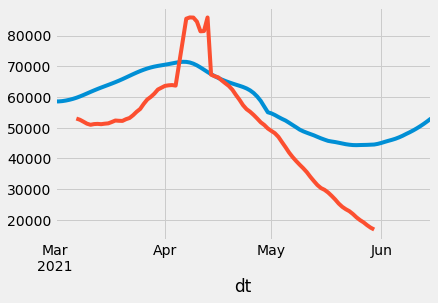

In [29]:
us_cases = df_st_testing_fmt['cases'][df_census.state.unique()].sum(axis=1, skipna=False).dropna().diff()
df_fore_allstates['US'].unstack('metric').loc['2021-03-01':'2021-06-15', 'exposed_daily'].plot()
us_cases.loc['2021-03-01':'2021-06-15'].rolling(7).mean().plot()

dt
2020-04-20        NaN
2020-04-21    33923.0
2020-04-22    36232.0
2020-04-23    35714.0
2020-04-24    38665.0
               ...   
2021-05-26    20932.0
2021-05-27    19412.0
2021-05-28    16706.0
2021-05-29    13076.0
2021-05-30     9173.0
Length: 404, dtype: float64